<a href="https://colab.research.google.com/github/Ausmints/demo-repo/blob/main/Copy_of_Football_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download prajitdatta/ultimate-25k-matches-football-database-european
! unzip /content/ultimate-25k-matches-football-database-european.zip

 73% 24.0M/32.7M [00:01<00:00, 20.8MB/s]
100% 32.7M/32.7M [00:01<00:00, 19.3MB/s]
Archive:  /content/ultimate-25k-matches-football-database-european.zip
  inflating: database.sqlite         


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [ ]:
sns.set()
colors = {"blue": "#4C72B0", "orange": "#DD8452", "green": "#55A868", "red": "#C44E52", "grey": "#8C8C8C"}

In [ ]:
import sqlite3
print(sqlite3.sqlite_version)  # needed 3.37.0
con = sqlite3.connect("database.sqlite")
cur = con.cursor()

3.22.0


In [ ]:
query = """
    SELECT name FROM sqlite_master WHERE type = "table"
    """

df = pd.read_sql_query(query, con)
df

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


##Team and League

In [ ]:
df = pd.read_sql_query("SELECT * from League", con)
df

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [ ]:
df = pd.read_sql_query("SELECT * from Country", con)
df

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [ ]:
df = pd.read_sql_query("SELECT * from Team LIMIT 10", con, index_col="id")
df

,team_api_id,team_fifa_api_id,team_long_name,team_short_name
id,,,,
1,9987,673.0,KRC Genk,GEN
2,9993,675.0,Beerschot AC,BAC
3,10000,15005.0,SV Zulte-Waregem,ZUL
4,9994,2007.0,Sporting Lokeren,LOK
5,9984,1750.0,KSV Cercle Brugge,CEB
6,8635,229.0,RSC Anderlecht,AND
7,9991,674.0,KAA Gent,GEN
8,9998,1747.0,RAEC Mons,MON
9,7947,NaN,FCV Dender EH,DEN


In [ ]:
df = pd.read_sql_query("SELECT * from Team ORDER BY 2", con, index_col="id")
df.shape[0]

299

In [ ]:
df.isnull().sum().sum()

11

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 31446 to 2510
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   team_api_id       299 non-null    int64  
 1   team_fifa_api_id  288 non-null    float64
 2   team_long_name    299 non-null    object 
 3   team_short_name   299 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.7+ KB


In [ ]:
query = """
  WITH sub AS (
    SELECT DISTINCT home_team_api_id AS team_id, country_id
    FROM Match
  ), sub2 AS (
    SELECT DISTINCT away_team_api_id AS team_id, country_id
    FROM Match
  ), sub3 AS (
    SELECT * FROM sub
    UNION
    SELECT * FROM sub2
  )
  SELECT s.country_id, c.name country, s.team_id, t.team_long_name team_name
  FROM sub3 s
  INNER JOIN Country c
  ON c.id = s.country_id
  INNER JOIN Team t
  ON t.team_api_id = s.team_id
"""

team_df = pd.read_sql_query(query, con)
team_df.head()

,country_id,country,team_id,team_name
0,15722,Poland,1601,Ruch Chorzów
1,1,Belgium,1773,Oud-Heverlee Leuven
2,15722,Poland,1957,Jagiellonia Białystok
3,17642,Portugal,2033,S.C. Olhanense
4,15722,Poland,2182,Lech Poznań


In [ ]:
team_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country_id  299 non-null    int64 
 1   country     299 non-null    object
 2   team_id     299 non-null    int64 
 3   team_name   299 non-null    object
dtypes: int64(2), object(2)
memory usage: 9.5+ KB


In [ ]:
team_df["country"].value_counts().to_frame()

,country
France,35
England,34
Spain,33
Italy,32
Germany,30
Portugal,29
Belgium,25
Netherlands,25
Poland,24
Scotland,17


In [ ]:
#Barplot here

In [ ]:
query = """
  WITH sub AS (
    SELECT home_team_api_id AS team_id, COUNT(*) home_count, country_id
    FROM Match
    GROUP BY 1
  ), sub2 AS (
    SELECT away_team_api_id AS team_id, COUNT(*) away_count, country_id
    FROM Match
    GROUP BY 1
  ), sub3 AS (
    SELECT s1.team_id, s1.home_count, s2.away_count, s1.country_id
    FROM sub s1
    INNER JOIN sub2 s2
    ON s1.team_id = s2.team_id
  )
  SELECT s.team_id, c.name country, t.team_long_name AS team_name, s.home_count, s.away_count
  FROM sub3 s
  INNER JOIN Team t
  ON t.team_api_id = s.team_id
  INNER JOIN Country c
  ON c.id = s.country_id
"""

df = pd.read_sql_query(query, con)
df

,team_id,country,team_name,home_count,away_count
0,1601,Poland,Ruch Chorzów,120,120
1,1773,Belgium,Oud-Heverlee Leuven,45,45
2,1957,Poland,Jagiellonia Białystok,120,120
3,2033,Portugal,S.C. Olhanense,75,75
4,2182,Poland,Lech Poznań,120,120
...,...,...,...,...,...
294,158085,Portugal,FC Arouca,49,49
295,177361,Poland,Termalica Bruk-Bet Nieciecza,15,15
296,188163,Portugal,Tondela,17,17
297,208931,Italy,Carpi,19,19


In [ ]:
df[df["home_count"] != df["away_count"]]

,team_id,country,team_name,home_count,away_count
65,8284,Scotland,Dundee FC,58,56
94,8467,Scotland,St. Johnstone FC,132,134
102,8524,Italy,Atalanta,132,131
107,8530,Italy,Catania,113,111
108,8533,Italy,Chievo Verona,152,151
113,8543,Italy,Lazio,151,150
121,8564,Italy,Milan,151,152
143,8636,Italy,Inter,151,152
159,8686,Italy,Roma,151,152
207,9857,Italy,Bologna,131,132


In [ ]:
df["count"] = df["home_count"] + df["away_count"]
df.sort_values("count", inplace=True, ascending=False)
df.drop(["home_count", "away_count"], axis=1, inplace=True)
df.head(10)

#Delete "home count" and "away count"

,team_id,country,team_name,count
193,9825,England,Arsenal,304
67,8302,Spain,Sevilla FC,304
118,8558,Spain,RCD Espanyol,304
228,9906,Spain,Atlético Madrid,304
130,8592,France,Olympique de Marseille,304
70,8315,Spain,Athletic Club de Bilbao,304
263,10194,England,Stoke City,304
154,8668,England,Everton,304
233,9925,Scotland,Celtic,304
68,8305,Spain,Getafe CF,304


In [ ]:
df.tail(10)

,team_id,country,team_name,count
76,8357,Germany,SpVgg Greuther Fürth,34
22,6631,Netherlands,FC Dordrecht,34
83,8398,Germany,FC Energie Cottbus,34
232,9912,Germany,DSC Arminia Bielefeld,34
8,4064,Portugal,Feirense,30
268,10213,Portugal,Amadora,30
36,7992,Portugal,Trofense,30
171,9765,Portugal,Portimonense,30
295,177361,Poland,Termalica Bruk-Bet Nieciecza,30
12,6351,Belgium,KAS Eupen,30


In [ ]:
df["count"].describe()

count    299.000000
mean     173.772575
std       96.448104
min       30.000000
25%       76.000000
50%      190.000000
75%      266.000000
max      304.000000
Name: count, dtype: float64

##Team attributes

In [ ]:
df = pd.read_sql_query("SELECT * from Team_Attributes", con)
df.head(10)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
5,6,77,8485,2012-02-22 00:00:00,58,Balanced,NaN,Little,62,Mixed,...,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,7,77,8485,2013-09-20 00:00:00,62,Balanced,NaN,Little,45,Mixed,...,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover
7,8,77,8485,2014-09-19 00:00:00,58,Balanced,64.0,Normal,62,Mixed,...,57,Normal,Organised,41,Medium,42,Press,60,Normal,Cover
8,9,77,8485,2015-09-10 00:00:00,59,Balanced,64.0,Normal,53,Mixed,...,63,Normal,Free Form,49,Medium,45,Press,63,Normal,Cover
9,10,614,8576,2010-02-22 00:00:00,60,Balanced,NaN,Little,40,Mixed,...,55,Normal,Organised,30,Deep,70,Double,30,Narrow,Offside Trap


In [ ]:
df.shape

(1458, 25)

In [ ]:
df.isnull().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


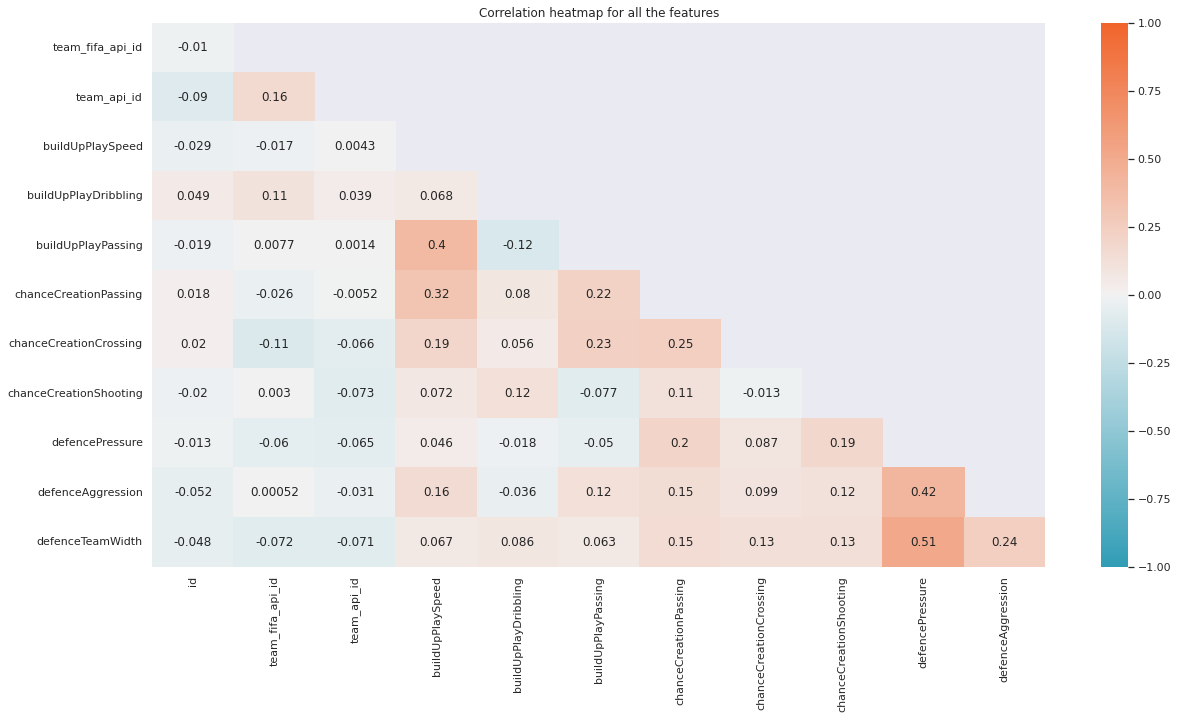

In [ ]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
mask = mask[1:, :-1]
corr = df.corr().iloc[1:,:-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin= -1, vmax=1)
ax.set_title("Correlation heatmap for all the features")
plt.show()

In [ ]:
df["buildUpPlayDribbling"].corr(pd.Series(pd.factorize(df["buildUpPlayDribblingClass"])[0]))

0.6771441870613697

In [ ]:
query = """
  SELECT STRFTIME('%Y', date) AS year, buildUpPlayDribbling
  FROM Team_Attributes
"""

df = pd.read_sql_query(query, con)
df[df["buildUpPlayDribbling"].isnull()]["year"].value_counts()

2011    244
2012    242
2013    242
2010    241
Name: year, dtype: int64

In [ ]:
df[~df["buildUpPlayDribbling"].isnull()]["year"].value_counts()

2015    245
2014    244
Name: year, dtype: int64

In [ ]:
team_attributes_df = pd.read_sql_query("SELECT * from Team_Attributes", con)

In [ ]:
team_attributes_df["date"] = pd.to_datetime(team_attributes_df["date"])

In [ ]:
team_attributes_df[~team_attributes_df["buildUpPlayDribbling"].isnull()]["team_fifa_api_id"].unique().shape

(260,)

In [ ]:
means = team_attributes_df.groupby("buildUpPlayDribblingClass")["buildUpPlayDribbling"].mean()

In [ ]:
means

buildUpPlayDribblingClass
Little    30.485714
Lots      69.809524
Normal    49.043880
Name: buildUpPlayDribbling, dtype: float64

In [ ]:
team_attributes_df["dribbling_earliest"] = np.nan

In [ ]:
for team in team_attributes_df["team_fifa_api_id"].unique():
  team_values = team_attributes_df[team_attributes_df["team_fifa_api_id"] == team]
  earliest_value = 0
  if 2014 in team_values["date"].dt.year.values:
    earliest_value = list(team_values[team_values["date"].dt.year.values == 2014]["buildUpPlayDribbling"])[0]
  elif 2015 in team_values["date"].dt.year.values:
    earliest_value = list(team_values[team_values["date"].dt.year.values == 2015]["buildUpPlayDribbling"])[0]
  else:
    earliest_value = 1
    team_attributes_df.loc[team_attributes_df["team_fifa_api_id"] == team, "dribbling_earliest"] = list(means[team_attributes_df.loc[team_attributes_df["team_fifa_api_id"] == team, "buildUpPlayDribblingClass"]].round())
    continue

  team_attributes_df.loc[team_attributes_df["team_fifa_api_id"] == team, "dribbling_earliest"] = list(((earliest_value + means[team_attributes_df.loc[team_attributes_df["team_fifa_api_id"] == team, "buildUpPlayDribblingClass"]])/2).round())


In [ ]:
team_attributes_df["buildUpPlayDribbling"].fillna(team_attributes_df["dribbling_earliest"], inplace=True)
team_attributes_df.drop(["dribbling_earliest"], axis=1, inplace=True)

In [ ]:
team_attributes_df.head(5)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22,60,Balanced,39.0,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22,70,Fast,47.0,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22,47,Balanced,47.0,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [ ]:
query = """
  SELECT team_api_id AS team_id, COUNT(*) count
  FROM Team_Attributes
  GROUP BY 1
"""

df = pd.read_sql_query(query, con)
df.shape

(288, 2)

In [ ]:
df["count"].value_counts()

6    189
5     28
3     20
2     19
4     18
1     14
Name: count, dtype: int64

In [ ]:
missing_teams = team_df[~team_df["team_id"].isin(df["team_id"].values)]

In [ ]:
missing_teams["country"].value_counts()

Portugal       6
Belgium        2
Netherlands    1
Switzerland    1
Poland         1
Name: country, dtype: int64

In [ ]:
missing_teams

,country_id,country,team_id,team_name
7,1,Belgium,4049,Tubize
8,17642,Portugal,4064,Feirense
13,17642,Portugal,6367,Uniao da Madeira
21,13274,Netherlands,6601,FC Volendam
32,24558,Switzerland,7896,Lugano
34,1,Belgium,7947,FCV Dender EH
36,17642,Portugal,7992,Trofense
171,17642,Portugal,9765,Portimonense
268,17642,Portugal,10213,Amadora
295,15722,Poland,177361,Termalica Bruk-Bet Nieciecza


In [ ]:
query = """
  SELECT STRFTIME('%Y', date) AS year
  FROM Team_Attributes
"""

df = pd.read_sql_query(query, con)
df.value_counts()

year
2015    245
2011    244
2014    244
2012    242
2013    242
2010    241
dtype: int64

##Player

In [ ]:
df = pd.read_sql_query("SELECT * from Player", con)
df.head(10)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154
5,6,27316,Aaron Hunt,158138,1986-09-04 00:00:00,182.88,161
6,7,564793,Aaron Kuhl,221280,1996-01-30 00:00:00,172.72,146
7,8,30895,Aaron Lennon,152747,1987-04-16 00:00:00,165.10,139
8,9,528212,Aaron Lennox,206592,1993-02-19 00:00:00,190.50,181
9,10,101042,Aaron Meijers,188621,1987-10-28 00:00:00,175.26,170


In [ ]:
df.shape

(11060, 7)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
query = """
  SELECT STRFTIME('%Y', birthday) AS year
  FROM Player
"""

df = pd.read_sql_query(query, con)
df.max()

year    1999
dtype: object

In [ ]:
df.min()

year    1967
dtype: object

In [ ]:
player_attributes_df = pd.read_sql_query("SELECT * from Player_Attributes", con)
player_attributes_df.head(5)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [ ]:
player_attributes_df.shape

(183978, 42)

In [ ]:
player_attributes_df.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [ ]:
(player_attributes_df.isnull().sum()/player_attributes_df.shape[0]).max()

0.017556446966485124

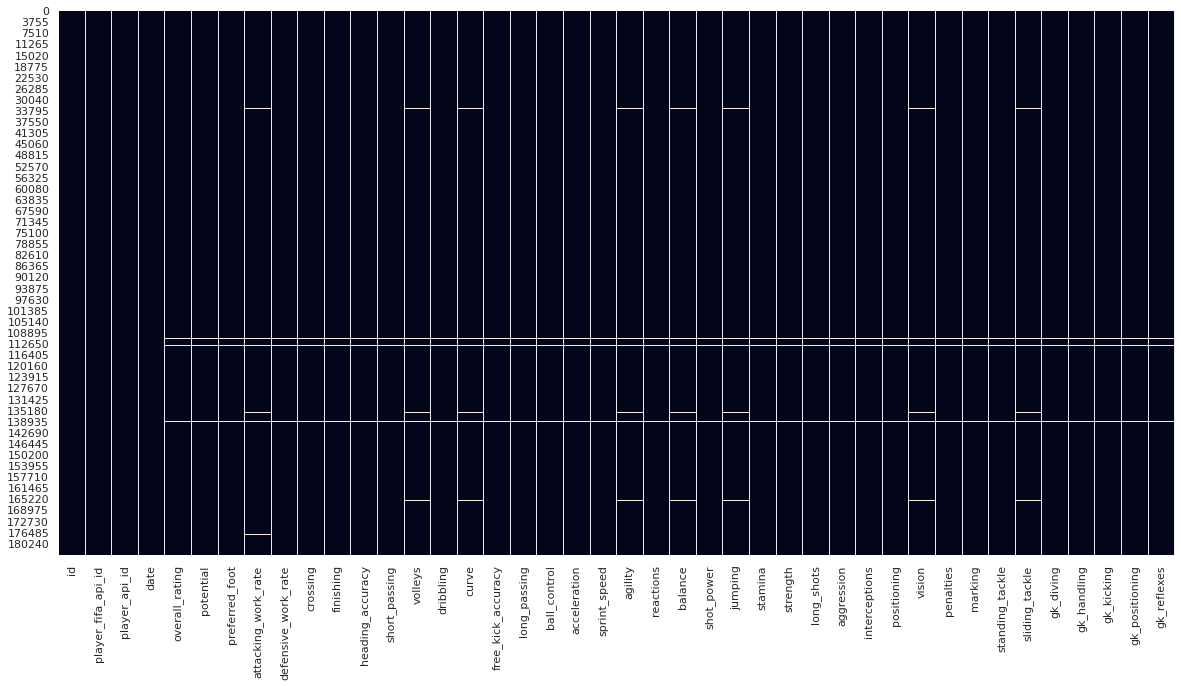

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(player_attributes_df.isnull(), cbar=False)
plt.show()

In [ ]:
query = """
  SELECT player_api_id AS player_id, COUNT(*) count
  FROM Player_Attributes
  GROUP BY 1
"""

df = pd.read_sql_query(query, con)
df.shape

(11060, 2)

In [ ]:
df["count"].value_counts().head(10)

8     498
7     491
6     484
9     442
5     433
18    404
20    397
4     393
19    392
10    391
Name: count, dtype: int64

In [ ]:
player_attributes_df[player_attributes_df["defensive_work_rate"].isin(["medium", "high", "low"])]["player_api_id"].unique().shape

(9938,)

In [ ]:
player_attributes_df["defensive_work_rate"].value_counts()

medium    130846
high       27041
low        18432
_0          2394
o           1550
1            441
ormal        348
2            342
3            258
5            234
7            217
0            197
6            197
9            152
4            116
es           106
ean          104
tocky         89
8             78
Name: defensive_work_rate, dtype: int64

In [ ]:
player_attributes_df[player_attributes_df["defensive_work_rate"]=="ean"].head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
925,926,192670,176302,2010-08-30 00:00:00,62.0,66.0,right,le,ean,61.0,...,60.0,56.0,52.0,54.0,47.0,8.0,9.0,12.0,15.0,11.0
926,927,192670,176302,2010-02-22 00:00:00,54.0,57.0,right,le,ean,43.0,...,60.0,48.0,48.0,48.0,47.0,3.0,23.0,49.0,23.0,23.0
927,928,192670,176302,2009-08-30 00:00:00,53.0,57.0,right,le,ean,43.0,...,60.0,48.0,48.0,48.0,47.0,3.0,23.0,49.0,23.0,23.0
928,929,192670,176302,2007-02-22 00:00:00,53.0,57.0,right,le,ean,43.0,...,60.0,48.0,48.0,48.0,47.0,3.0,23.0,49.0,23.0,23.0
3233,3234,183243,121923,2009-02-22 00:00:00,68.0,71.0,right,le,ean,49.0,...,NaN,50.0,21.0,22.0,NaN,9.0,21.0,53.0,21.0,21.0


In [ ]:
player_attributes_df["preferred_foot"].value_counts()

right    138409
left      44733
Name: preferred_foot, dtype: int64

In [ ]:
player_attributes_df["attacking_work_rate"].value_counts()

medium    125070
high       42823
low         8569
None        3639
norm         348
y            106
le           104
stoc          89
Name: attacking_work_rate, dtype: int64

In [ ]:
work_rate_values = ["medium", "high", "low"]
player_attributes_df.loc[~player_attributes_df["defensive_work_rate"].isin(work_rate_values), "defensive_work_rate"] = np.nan

In [ ]:
player_attributes_df.loc[~player_attributes_df["attacking_work_rate"].isin(work_rate_values), "attacking_work_rate"] = np.nan

In [ ]:
player_attributes_df.isnull().sum(axis=1).value_counts()

0     176161
2       4645
9       1877
38       836
1        459
dtype: int64

In [ ]:
player_attributes_df.loc[player_attributes_df.isnull().sum(axis=1)> 10].head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
483,484,33022,31684,2007-02-22 00:00:00,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,984,111085,29904,2007-02-22 00:00:00,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1753,165740,24159,2007-02-22 00:00:00,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2089,2090,176941,31916,2007-02-22 00:00:00,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2482,2483,177615,37249,2007-02-22 00:00:00,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
player_attributes_df[player_attributes_df["player_api_id"] == 31684]

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
478,479,33022,31684,2009-08-30 00:00:00,73.0,76.0,right,NaN,NaN,56.0,...,NaN,68.0,76.0,75.0,NaN,5.0,23.0,71.0,23.0,23.0
479,480,33022,31684,2009-02-22 00:00:00,77.0,79.0,right,NaN,NaN,68.0,...,NaN,69.0,83.0,78.0,NaN,5.0,23.0,76.0,23.0,23.0
480,481,33022,31684,2008-08-30 00:00:00,77.0,80.0,right,NaN,NaN,68.0,...,NaN,69.0,83.0,78.0,NaN,5.0,23.0,76.0,23.0,23.0
481,482,33022,31684,2007-08-30 00:00:00,78.0,79.0,right,NaN,NaN,72.0,...,NaN,69.0,80.0,76.0,NaN,5.0,23.0,76.0,23.0,23.0
482,483,33022,31684,2007-02-22 00:00:00,78.0,79.0,right,NaN,NaN,72.0,...,NaN,69.0,80.0,76.0,NaN,5.0,10.0,76.0,10.0,7.0
483,484,33022,31684,2007-02-22 00:00:00,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
value_counts = player_attributes_df.loc[player_attributes_df.isnull().sum(axis=1)> 10, "player_api_id"].value_counts()

In [ ]:
(player_attributes_df.loc[player_attributes_df["player_api_id"].isin(list(player_attributes_df.loc[player_attributes_df.isnull().sum(axis=1)> 10, "player_api_id"].unique())), "player_api_id"].value_counts() - value_counts < 1).any()

False

In [ ]:
player_attributes_df["player_api_id"].unique().shape

(11060,)

In [ ]:
player_attributes_df.drop(player_attributes_df[player_attributes_df.isnull().sum(axis=1)> 10].index, inplace=True)

In [ ]:
player_attributes_df["player_api_id"].unique().shape

(11060,)

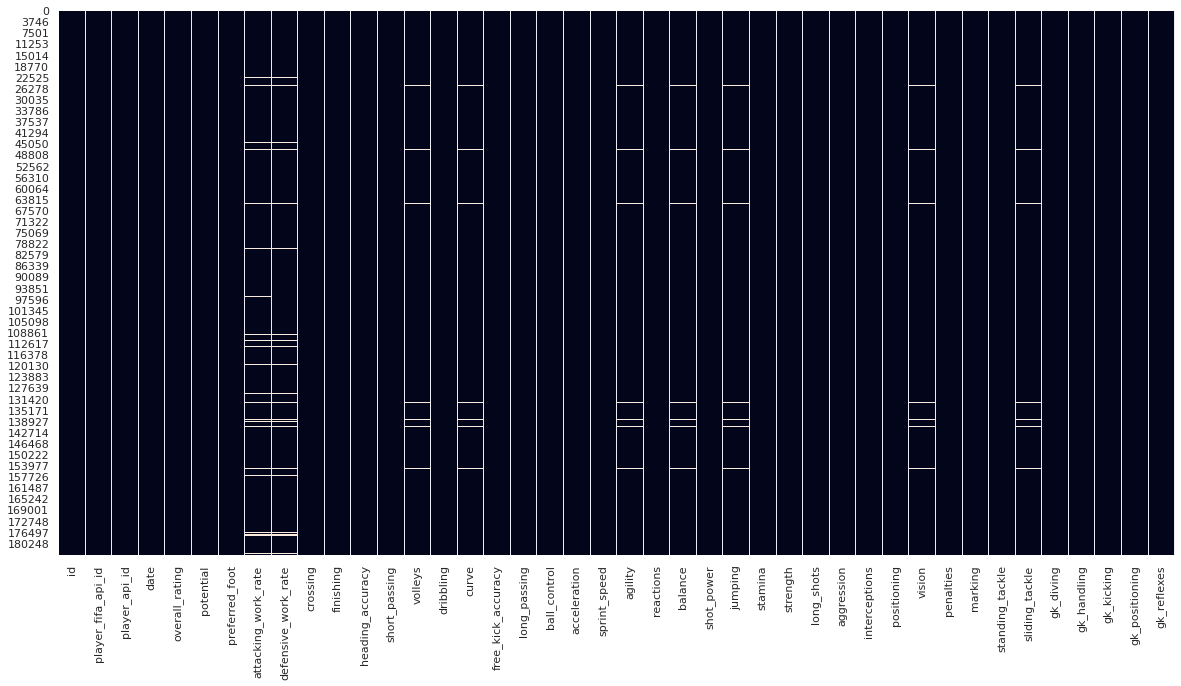

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(player_attributes_df.isnull(), cbar=False)
plt.show()

In [ ]:
query = """
  WITH sub AS (
    SELECT STRFTIME('%Y', date) AS year
    FROM Player_Attributes
    )
  SELECT year, COUNT(*) count
  FROM sub
  GROUP BY 1
"""

df = pd.read_sql_query(query, con)
df.sort_values("year")

#Divide by season not year all of these year specific ones

,year,count
0,2007,16138
1,2008,5798
2,2009,8993
3,2010,10829
4,2011,11976
5,2012,12632
6,2013,38867
7,2014,32808
8,2015,31834
9,2016,14103


In [ ]:
query = """
  WITH sub AS (
    SELECT STRFTIME('%Y', date) AS year, player_api_id AS player_id, COUNT(*) count
    FROM Player_Attributes
    GROUP BY 2, 1
  )
  SELECT year, COUNT(*) count
  FROM sub
  GROUP BY 1
"""

df = pd.read_sql_query(query, con)
df.sort_values("year")

,year,count
0,2007,11060
1,2008,5422
2,2009,6147
3,2010,6930
4,2011,7261
5,2012,7459
6,2013,7896
7,2014,7796
8,2015,7502
9,2016,5586


In [ ]:
df = pd.read_sql_query("SELECT * from Match", con)
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [ ]:
df["home_player_Y1"].value_counts()

1.0    24146
0.0       11
3.0        1
Name: home_player_Y1, dtype: int64

In [ ]:
df["home_formation"] = ["-".join(str(y) for y in list(np.bincount(x))) if (-2147483648 not in x) else np.nan for x in df[df.loc[:, "home_player_Y1":"home_player_Y11"].columns.tolist()].to_numpy().astype("int32")] 
df["home_formation"] = df["home_formation"].str.replace("0-", "")

In [ ]:
df["away_formation"] = ["-".join(str(y) for y in list(np.bincount(x))) if (-2147483648 not in x) else np.nan for x in df[df.loc[:, "away_player_Y1":"away_player_Y11"].columns.tolist()].to_numpy().astype("int32")] 
df["away_formation"] = df["away_formation"].str.replace("0-", "")

In [ ]:
df["home_formation"].value_counts()

1-4-2-3-1      6431
1-4-4-2        6425
1-4-3-3        4375
1-4-5-1         943
1-4-4-1-1       879
1-3-5-2         685
1-4-3-1-2       681
1-4-1-4-1       632
1-4-1-2-1-2     565
1-4-2-2-2       552
1-4-1-2-2-1     373
1-3-4-3         283
1-4-1-3-2       253
1-4-3-2-1       240
1-5-3-2         187
1-3-4-2-1       166
1-3-4-1-2       145
1-3-5-1-1       123
1-4-1-2-3        79
1-5-4-1          70
1-4-2-1-3        35
1-3-2-3-2        13
1-3-3-3-1         8
1-5-3-1-1         2
2-6-3             1
2-4-2-2-1         1
Name: home_formation, dtype: int64

In [ ]:
df["away_formation"].value_counts()

1-4-2-3-1      6454
1-4-4-2        6078
1-4-3-3        4354
1-4-5-1        1224
1-4-4-1-1       846
1-4-1-4-1       708
1-3-5-2         696
1-4-3-1-2       613
1-4-2-2-2       547
1-4-1-2-1-2     513
1-4-1-2-2-1     366
1-3-4-3         283
1-4-3-2-1       264
1-4-1-3-2       238
1-5-3-2         193
1-3-4-2-1       184
1-3-5-1-1       147
1-5-4-1         137
1-3-4-1-2       136
1-4-1-2-3        93
1-4-2-1-3        34
1-3-2-3-2        16
1-3-3-3-1        13
1-5-3-1-1         2
1-3-1-3-1-2       1
Name: away_formation, dtype: int64

In [ ]:
df.shape

(25979, 117)

In [ ]:
df.drop(df.loc[:, "home_player_X1":"away_player_Y11"].columns.tolist(), axis=1, inplace=True)

In [ ]:
null_df = pd.DataFrame()
null_df["count"] = df.isnull().sum()
null_df["percentage"] = null_df["count"]/df.shape[0]
null_df["percentage"].value_counts().sort_index()

0.000000    11
0.047115     1
0.047230     1
0.047500     1
0.047538     1
0.049001     1
0.049194     1
0.049309     1
0.049771     1
0.050387     1
0.050541     1
0.050618     1
0.050656     1
0.050849     1
0.050926     1
0.051003     1
0.051118     1
0.051388     1
0.051619     1
0.055275     1
0.055468     1
0.059818     1
0.059856     1
0.070518     1
0.070788     1
0.130375     3
0.131029     3
0.131183     3
0.131298     3
0.131760     3
0.133146     3
0.341892     3
0.452750     8
0.454867     3
0.454906     3
0.570114     3
Name: percentage, dtype: int64

In [ ]:
null_df[null_df["percentage"] > 0.15]

,count,percentage
goal,11762,0.452750
shoton,11762,0.452750
shotoff,11762,0.452750
foulcommit,11762,0.452750
card,11762,0.452750
cross,11762,0.452750
corner,11762,0.452750
possession,11762,0.452750
PSH,14811,0.570114
PSD,14811,0.570114


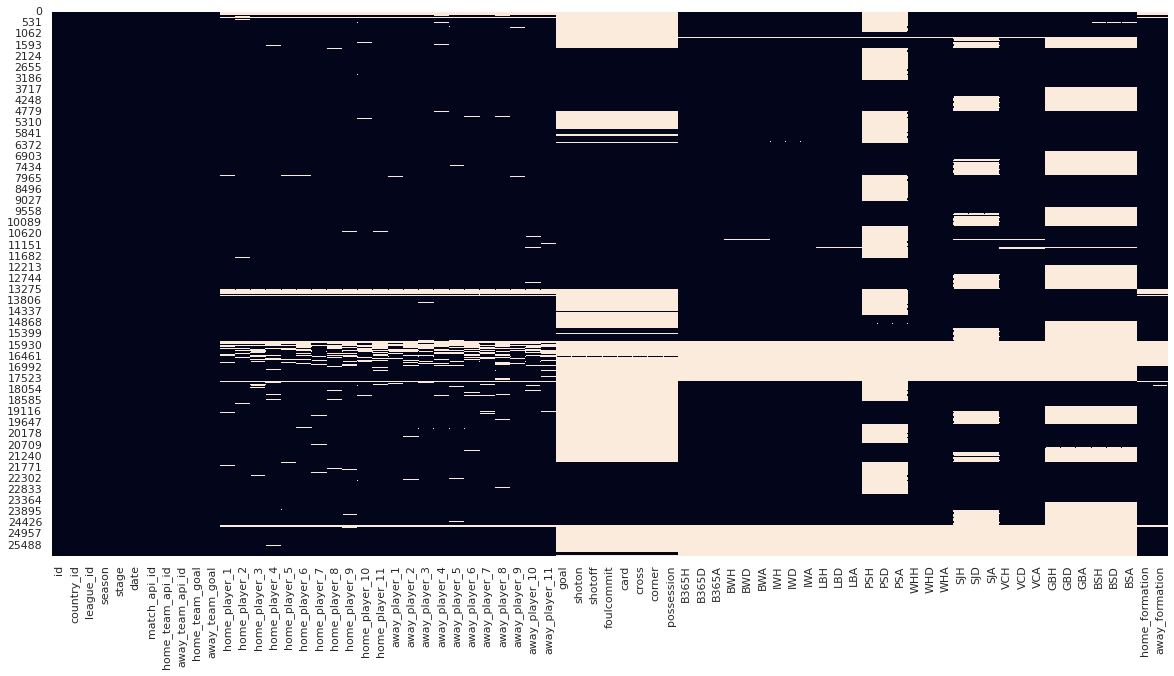

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
pd.unique(df.loc[:, ["away_team_api_id", "home_team_api_id"]].values.ravel("K")).shape[0]

299

In [ ]:
pd.unique(df[~df["away_formation"].isnull()].loc[:, ["away_team_api_id", "home_team_api_id"]].values.ravel("K")).shape[0]

294

In [ ]:
missing_formation_list = pd.unique(df[df["away_formation"].isnull()].loc[:, ["away_team_api_id", "home_team_api_id"]].values.ravel("K")).tolist()

In [ ]:
for id in missing_formation_list:
   formation_list = pd.Series(data = (df[df["away_team_api_id"] == id]["away_formation"].tolist() + df[df["home_team_api_id"] == id]["home_formation"].tolist()))
   if ~formation_list.isnull().all():
    df.loc[df["away_team_api_id"] == id, "away_formation"] = df.loc[df["away_team_api_id"] == id, "away_formation"].fillna(formation_list.value_counts().index[0])
    df.loc[df["home_team_api_id"] == id, "home_formation"] = df.loc[df["home_team_api_id"] == id, "home_formation"].fillna(formation_list.value_counts().index[0])

In [ ]:
df.loc[:, "home_formation"] = df.loc[:, "home_formation"].fillna(df["home_formation"].value_counts().index[0])
df.loc[:, "away_formation"] = df.loc[:, "away_formation"].fillna(df["away_formation"].value_counts().index[0])

In [ ]:
df[df["shoton"].isnull()]["season"].value_counts()

2008/2009    1875
2009/2010    1777
2010/2011    1575
2011/2012    1507
2012/2013    1435
2014/2015    1293
2013/2014    1206
2015/2016    1094
Name: season, dtype: int64

In [ ]:
df[df["shoton"].isnull()]["league_id"].value_counts()

17642    2052
13274    1918
15722    1913
19694    1811
1        1728
24558    1322
4769     1014
10257       3
21518       1
Name: league_id, dtype: int64

In [ ]:
df[~df["shoton"].isnull()]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_formation,away_formation
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00,1-4-4-2,1-4-4-1-1
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00,1-4-4-2,1-4-5-1
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73,1-4-4-2,1-4-4-2
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80,1-4-4-2,1-4-4-2
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75,1-4-4-2,1-4-5-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25944,25945,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992225,9931,9956,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-2-3-1
25945,25946,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992226,7896,10190,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-3-3,1-4-1-4-1
25946,25947,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992227,10199,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-4-2
25947,25948,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992228,10191,10192,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-4-2,1-4-4-2


In [ ]:
temp_df = df[~df["shoton"].isnull()].copy()

In [ ]:
temp_df.set_index("match_api_id", inplace=True)

In [ ]:
event_df = pd.DataFrame()

In [ ]:
for column in temp_df.loc[:, "goal":"possession"].columns:
  column_df = temp_df.loc[:,column].str.split("</value>", expand=True).stack().reset_index().rename(columns={"level_0":"match_id", 0:"string"})
  column_df["event"] = column
  column_df["player_id"] = column_df["string"].str.extract("<player1>(\d+)<\/player1>")
  column_df["player2_id"] = column_df["string"].str.extract("<player2>(\d+)<\/player2>")
  column_df["team_id"] = column_df["string"].str.extract("<team>(\d+)<\/team>")
  column_df.drop(["level_1", "string"], axis=1, inplace=True)
  event_df = pd.concat([event_df, column_df])

In [ ]:
event_df["event"].value_counts()

cross         541316
foulcommit    447103
shoton        193936
shotoff       193932
corner        182066
goal           76353
card           76331
possession     49032
Name: event, dtype: int64

In [ ]:
event_df["player_id"].value_counts(dropna=False)

NaN       902754
30618       2522
24846       2499
23354       2479
30892       2372
           ...  
23336          1
40988          1
179769         1
409221         1
213796         1
Name: player_id, Length: 6893, dtype: int64

In [ ]:
player_games_stats = pd.Series(temp_df.loc[:, "home_player_1":"away_player_11"].values.ravel("K")).dropna().astype(int).value_counts()

In [ ]:
player_games_stats

33764     286
42422     286
31465     282
31432     275
30893     259
         ... 
50651       1
210693      1
46689       1
40549       1
636565      1
Length: 6744, dtype: int64

In [ ]:
player_attributes_df = pd.merge(player_attributes_df, player_games_stats.rename("game_count"), how="left", left_on="player_api_id", right_index=True)

In [ ]:
for event in event_df["event"].unique():
  feature = event_df[event_df["event"]==event].groupby("player_id").count()["event"]
  feature.index = feature.index.astype(int)
  if len(feature) == 0:
    continue
  print(len(feature))
  player_attributes_df = pd.merge(player_attributes_df, feature.rename(event+"_raw"), how="left", left_on="player_api_id", right_index=True)
  player_attributes_df[event] = player_attributes_df[event+"_raw"]/player_attributes_df["game_count"]
  player_attributes_df.drop(event+"_raw", inplace=True, axis=1)

4355
4633
4800
5617
5864
5137
2956


In [ ]:
player_attributes_df

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_positioning,gk_reflexes,game_count,goal,shoton,shotoff,foulcommit,card,cross,corner
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,183974,102359,39902,2009-08-30 00:00:00,83.0,85.0,right,medium,low,84.0,...,20.0,20.0,64.0,0.25,0.34375,0.28125,0.4375,0.1875,2.1875,1.84375
183974,183975,102359,39902,2009-02-22 00:00:00,78.0,80.0,right,medium,low,74.0,...,20.0,20.0,64.0,0.25,0.34375,0.28125,0.4375,0.1875,2.1875,1.84375
183975,183976,102359,39902,2008-08-30 00:00:00,77.0,80.0,right,medium,low,74.0,...,20.0,20.0,64.0,0.25,0.34375,0.28125,0.4375,0.1875,2.1875,1.84375
183976,183977,102359,39902,2007-08-30 00:00:00,78.0,81.0,right,medium,low,74.0,...,20.0,20.0,64.0,0.25,0.34375,0.28125,0.4375,0.1875,2.1875,1.84375


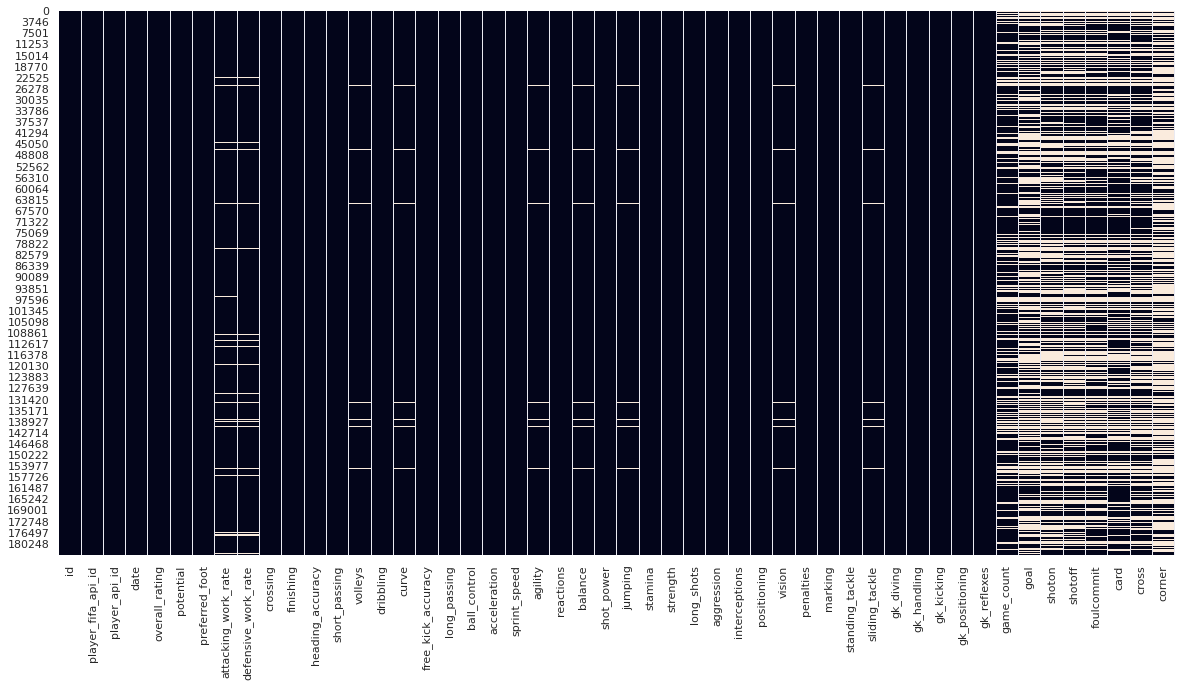

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(player_attributes_df.isnull(), cbar=False)
plt.show()

In [ ]:
player_attributes_df.loc[~player_attributes_df["game_count"].isnull(),"game_count":"corner"]

,game_count,goal,shoton,shotoff,foulcommit,card,cross,corner
5,75.0,0.053333,0.293333,0.24000,0.533333,0.0800,3.0000,0.026667
6,75.0,0.053333,0.293333,0.24000,0.533333,0.0800,3.0000,0.026667
7,75.0,0.053333,0.293333,0.24000,0.533333,0.0800,3.0000,0.026667
8,75.0,0.053333,0.293333,0.24000,0.533333,0.0800,3.0000,0.026667
9,75.0,0.053333,0.293333,0.24000,0.533333,0.0800,3.0000,0.026667
...,...,...,...,...,...,...,...,...
183973,64.0,0.250000,0.343750,0.28125,0.437500,0.1875,2.1875,1.843750
183974,64.0,0.250000,0.343750,0.28125,0.437500,0.1875,2.1875,1.843750
183975,64.0,0.250000,0.343750,0.28125,0.437500,0.1875,2.1875,1.843750
183976,64.0,0.250000,0.343750,0.28125,0.437500,0.1875,2.1875,1.843750


In [ ]:
player_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 0 to 183977
Data columns (total 50 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183142 non-null  int64  
 1   player_fifa_api_id   183142 non-null  int64  
 2   player_api_id        183142 non-null  int64  
 3   date                 183142 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  176462 non-null  object 
 8   defensive_work_rate  176319 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [ ]:
mean_player_attributes = player_attributes_df.groupby("player_api_id").mean()

In [ ]:
mean_player_attributes.loc[~mean_player_attributes["game_count"].isnull(),"overall_rating":"gk_reflexes"]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_api_id,,,,,,,,,,,,,,,,,,,,,
2625,60.142857,61.142857,50.142857,47.285714,46.285714,56.500000,38.000000,54.142857,50.000000,49.928571,...,55.285714,61.928571,62.928571,63.857143,56.571429,12.428571,12.857143,19.071429,10.357143,10.428571
2752,69.380952,70.380952,36.428571,37.428571,75.333333,54.809524,20.428571,44.857143,30.428571,18.857143,...,52.428571,35.428571,71.095238,70.666667,65.571429,11.095238,6.095238,7.095238,9.095238,15.095238
2768,69.285714,70.571429,42.238095,42.761905,66.666667,64.714286,28.761905,40.238095,51.761905,20.047619,...,57.761905,31.904762,71.666667,70.619048,79.714286,10.761905,15.904762,22.714286,15.142857,12.095238
2770,71.133333,73.533333,61.866667,67.666667,67.800000,72.533333,67.133333,75.066667,79.800000,68.666667,...,71.600000,63.933333,30.200000,37.533333,25.000000,8.666667,15.666667,27.200000,16.333333,17.000000
2790,70.200000,75.800000,70.000000,37.400000,55.200000,68.000000,43.000000,60.800000,67.000000,55.400000,...,60.000000,55.400000,74.600000,74.600000,69.000000,8.000000,17.000000,59.000000,16.600000,17.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733787,51.000000,68.250000,51.000000,30.000000,48.000000,31.000000,31.000000,59.000000,29.000000,30.000000,...,36.000000,40.000000,46.000000,53.000000,53.000000,14.000000,12.000000,8.000000,5.000000,6.000000
742405,51.000000,73.000000,40.000000,32.000000,50.000000,55.000000,40.000000,48.000000,38.000000,38.000000,...,47.000000,42.000000,38.000000,60.000000,55.000000,11.000000,12.000000,9.000000,14.000000,10.000000
743720,50.000000,66.500000,35.000000,32.000000,47.000000,61.000000,32.000000,44.000000,38.000000,40.000000,...,54.000000,40.000000,46.000000,42.000000,58.000000,10.000000,7.000000,15.000000,13.000000,8.000000


In [ ]:
mean_player_attributes.loc[~mean_player_attributes["game_count"].isnull(),"game_count":"corner"].fillna(0, inplace=True)

In [ ]:
corr_table = mean_player_attributes.loc[~mean_player_attributes["game_count"].isnull(),"overall_rating":].corr().loc["overall_rating":"gk_reflexes", "goal":"corner"]
corr_table[~corr_table[(corr_table>0.3)|(corr_table<-0.3)].isnull().all(axis=1)][(corr_table>0.3)|(corr_table<-0.3)]

,goal,shoton,shotoff,foulcommit,card,cross,corner
crossing,NaN,NaN,NaN,NaN,NaN,0.351520,NaN
finishing,0.467389,0.441838,0.422457,NaN,NaN,NaN,NaN
heading_accuracy,NaN,NaN,NaN,NaN,NaN,NaN,-0.318082
volleys,0.367652,0.333737,0.327547,NaN,NaN,NaN,NaN
dribbling,NaN,NaN,NaN,NaN,NaN,0.327368,NaN
free_kick_accuracy,NaN,NaN,NaN,NaN,NaN,NaN,0.323775
acceleration,NaN,NaN,NaN,NaN,NaN,0.316781,NaN
agility,NaN,NaN,NaN,NaN,NaN,0.308226,NaN
strength,NaN,NaN,NaN,NaN,NaN,-0.329592,NaN
aggression,NaN,-0.370637,-0.336725,NaN,NaN,NaN,NaN


In [ ]:
mean_player_attributes.info(
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 2625 to 750584
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               11060 non-null  float64
 1   id                  11060 non-null  float64
 2   player_fifa_api_id  11060 non-null  float64
 3   overall_rating      11060 non-null  float64
 4   potential           11060 non-null  float64
 5   crossing            11060 non-null  float64
 6   finishing           11060 non-null  float64
 7   heading_accuracy    11060 non-null  float64
 8   short_passing       11060 non-null  float64
 9   volleys             10582 non-null  float64
 10  dribbling           11060 non-null  float64
 11  curve               10582 non-null  float64
 12  free_kick_accuracy  11060 non-null  float64
 13  long_passing        11060 non-null  float64
 14  ball_control        11060 non-null  float64
 15  acceleration        11060 non-null  float64
 16  

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:

ii_imp = IterativeImputer(
    estimator=BayesianRidge(), max_iter=10, random_state=1121218
)

# Tranform
mean_player_attributes.loc[:, :] = ii_imp.fit_transform(mean_player_attributes)

In [ ]:
mean_player_attributes.isnull().sum().sum()

0

In [ ]:
mean_player_attributes

,index,id,player_fifa_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,gk_positioning,gk_reflexes,game_count,goal,shoton,shotoff,foulcommit,card,cross,corner
player_api_id,,,,,,,,,,,,,,,,,,,,,
2625,139849.5,139850.5,148544.0,60.142857,61.142857,50.142857,47.285714,46.285714,56.500000,38.000000,...,10.357143,10.428571,2.000000,0.359195,0.500000,0.500000,5.500000,1.214318,1.500000,0.550110
2752,44154.0,44155.0,135819.0,69.380952,70.380952,36.428571,37.428571,75.333333,54.809524,20.428571,...,9.095238,15.095238,81.000000,0.098765,0.049383,0.061728,0.333333,0.148148,0.024691,-0.025475
2768,88294.0,88295.0,110019.0,69.285714,70.571429,42.238095,42.761905,66.666667,64.714286,28.761905,...,15.142857,12.095238,71.000000,0.042254,0.056338,0.070423,0.323944,0.197183,0.028169,0.056338
2770,72148.0,72149.0,182861.0,71.133333,73.533333,61.866667,67.666667,67.800000,72.533333,67.133333,...,16.333333,17.000000,2.000000,0.300031,0.500000,0.518526,0.813777,0.315711,0.903293,0.669303
2790,5123.0,5124.0,110809.0,70.200000,75.800000,70.000000,37.400000,55.200000,68.000000,43.000000,...,16.600000,17.400000,50.000000,0.071792,0.020000,-0.006978,0.480000,0.320000,0.400000,-0.044726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744907,66606.0,66607.0,226508.0,51.909091,65.909091,42.454545,44.454545,47.454545,59.454545,42.454545,...,11.454545,8.454545,-45.964573,0.273032,0.612920,0.584737,1.350162,0.417040,1.065540,0.723627
746419,58304.5,58305.5,233930.0,59.000000,66.000000,55.000000,28.000000,50.000000,35.000000,29.000000,...,9.000000,9.000000,-7.221580,0.097615,0.429646,0.332291,1.222035,0.391650,2.538945,0.208589
748432,60179.5,60180.5,233969.0,58.000000,68.000000,48.000000,26.000000,57.000000,49.000000,24.000000,...,12.000000,6.000000,2.000000,0.171843,0.500000,0.450079,1.000000,0.380228,1.500000,0.104592


[]

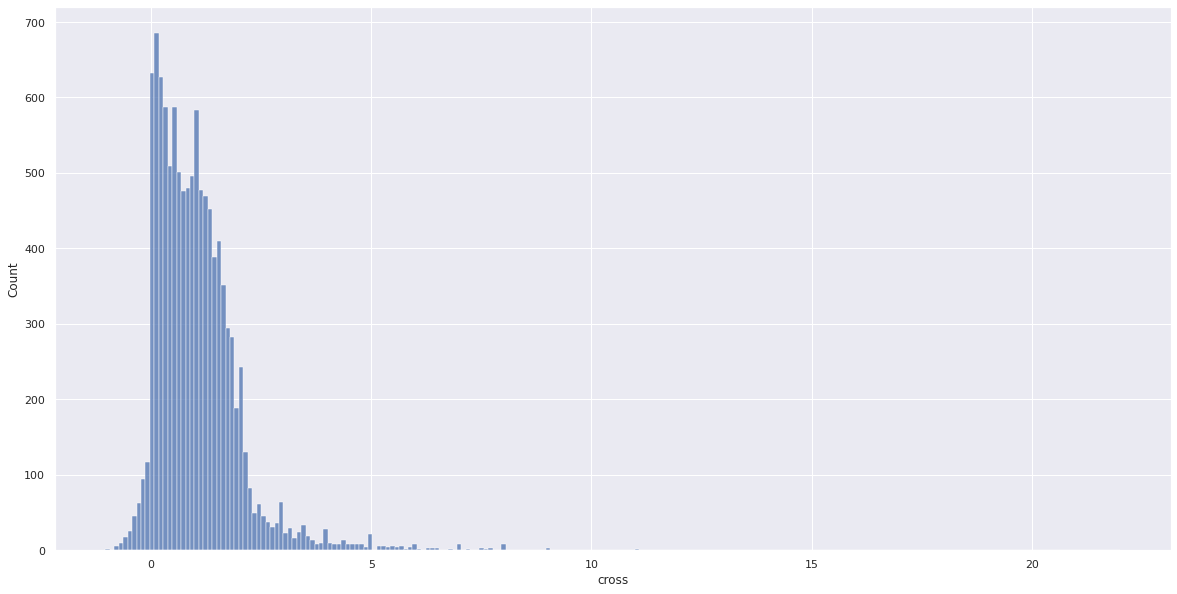

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(x=mean_player_attributes["cross"])
plt.plot()

In [ ]:
mean_player_attributes.min()[mean_player_attributes.min() < 0]

game_count   -134.868196
goal           -0.172519
shoton         -0.201222
shotoff        -0.154648
foulcommit     -0.559756
card           -0.265043
cross          -1.033104
corner         -0.755897
dtype: float64

In [ ]:
mean_player_attributes[mean_player_attributes < 0] = 0

In [ ]:
mean_player_attributes.min()[mean_player_attributes.min() == 0]

game_count    0.0
goal          0.0
shoton        0.0
shotoff       0.0
foulcommit    0.0
card          0.0
cross         0.0
corner        0.0
dtype: float64

[]

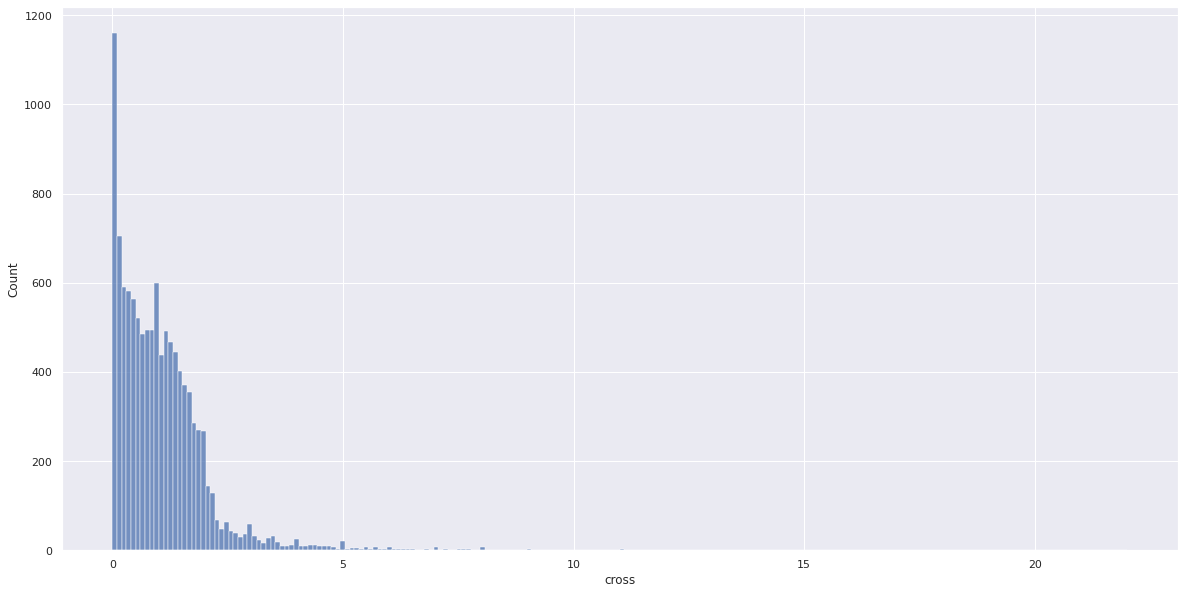

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(x=mean_player_attributes["cross"])
plt.plot()

In [ ]:
mean_player_attributes.max()[mean_player_attributes.max() > 100]

index                 183972.5
id                    183973.5
player_fifa_api_id    234141.0
game_count               286.0
dtype: float64

In [ ]:
player_attributes_df = player_attributes_df.reset_index().set_index("player_api_id")

In [ ]:
player_attributes_df

,index,id,player_fifa_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_positioning,gk_reflexes,game_count,goal,shoton,shotoff,foulcommit,card,cross,corner
player_api_id,,,,,,,,,,,,,,,,,,,,,
505942,0,1,218353,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505942,1,2,218353,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505942,2,3,218353,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505942,3,4,218353,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505942,4,5,218353,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39902,183973,183974,102359,2009-08-30 00:00:00,83.0,85.0,right,medium,low,84.0,...,20.0,20.0,64.0,0.25,0.34375,0.28125,0.4375,0.1875,2.1875,1.84375
39902,183974,183975,102359,2009-02-22 00:00:00,78.0,80.0,right,medium,low,74.0,...,20.0,20.0,64.0,0.25,0.34375,0.28125,0.4375,0.1875,2.1875,1.84375
39902,183975,183976,102359,2008-08-30 00:00:00,77.0,80.0,right,medium,low,74.0,...,20.0,20.0,64.0,0.25,0.34375,0.28125,0.4375,0.1875,2.1875,1.84375


In [ ]:
player_attributes_df = player_attributes_df.combine_first(mean_player_attributes)

In [ ]:
player_attributes_df.reset_index().set_index("index", inplace=True)

In [ ]:
player_attributes_df.isnull().sum()[player_attributes_df.isnull().sum()>0]

attacking_work_rate    6680
defensive_work_rate    6823
dtype: int64

In [ ]:
player_attributes_df["attacking_work_rate"].value_counts()

medium    125070
high       42823
low         8569
Name: attacking_work_rate, dtype: int64

In [ ]:
player_attributes_df["defensive_work_rate"].value_counts()

medium    130846
high       27041
low        18432
Name: defensive_work_rate, dtype: int64

In [ ]:
player_attributes_df.fillna("medium", inplace=True)

In [ ]:
player_attributes_df["defensive_work_rate"].value_counts()

medium    137669
high       27041
low        18432
Name: defensive_work_rate, dtype: int64

In [ ]:
words_to_values = {"medium":5, "low":1, "high":9}

In [ ]:
player_attributes_df.loc[:,["defensive_work_rate","attacking_work_rate"]] = player_attributes_df.loc[:,["defensive_work_rate","attacking_work_rate"]].replace(words_to_values)

In [ ]:
player_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 2625 to 750584
Data columns (total 50 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   acceleration         183142 non-null  float64
 1   aggression           183142 non-null  float64
 2   agility              183142 non-null  float64
 3   attacking_work_rate  183142 non-null  int64  
 4   balance              183142 non-null  float64
 5   ball_control         183142 non-null  float64
 6   card                 183142 non-null  float64
 7   corner               183142 non-null  float64
 8   cross                183142 non-null  float64
 9   crossing             183142 non-null  float64
 10  curve                183142 non-null  float64
 11  date                 183142 non-null  object 
 12  defensive_work_rate  183142 non-null  int64  
 13  dribbling            183142 non-null  float64
 14  finishing            183142 non-null  float64
 15  foulcommit    

[]

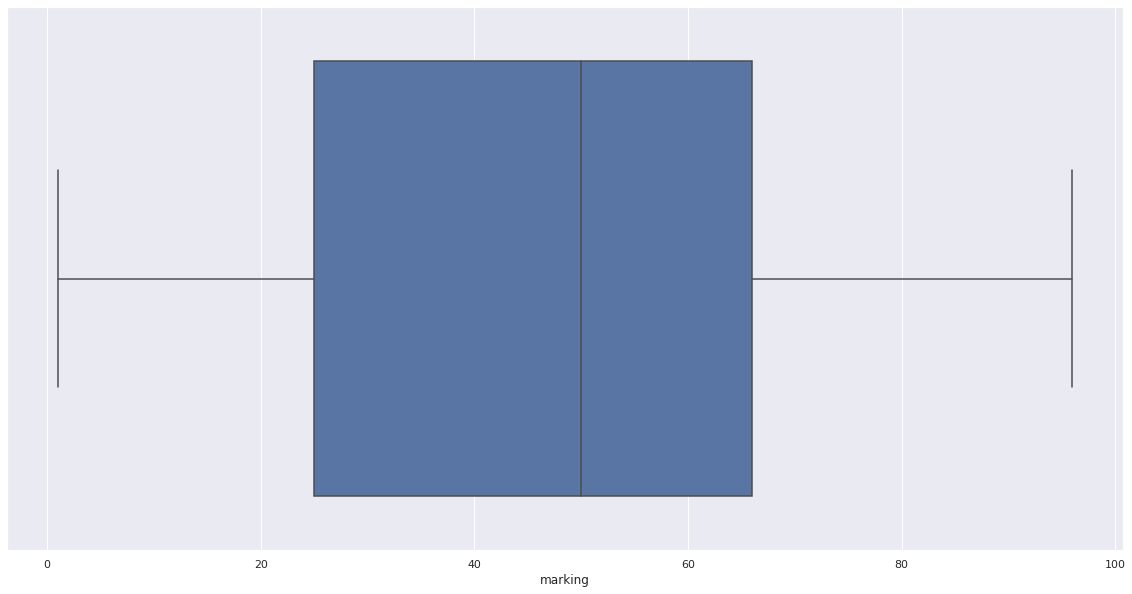

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=player_attributes_df["marking"])
plt.plot()

[]

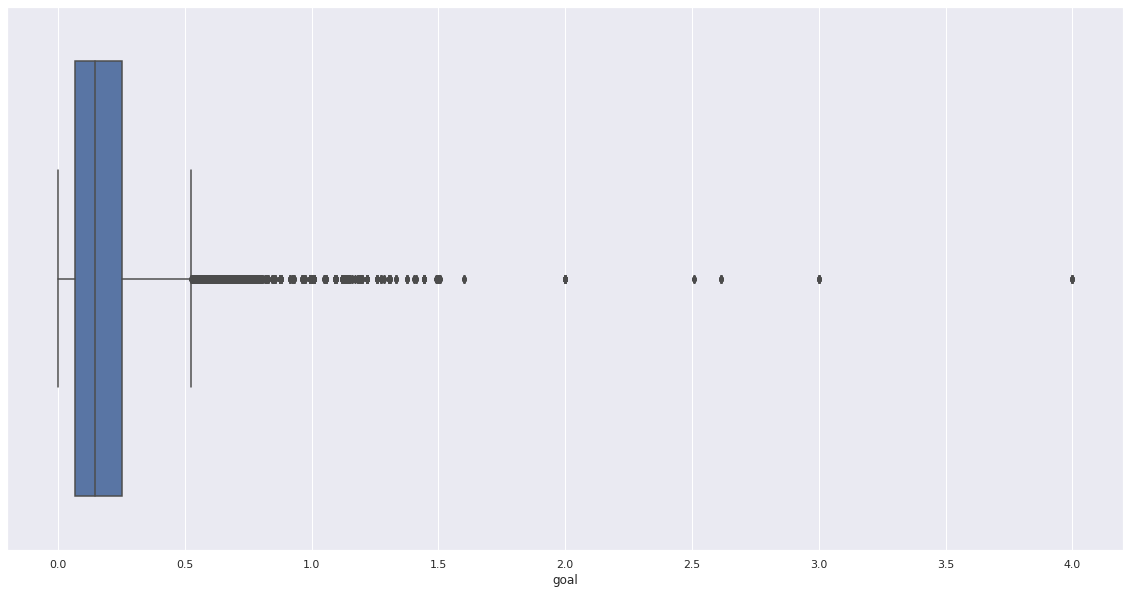

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=player_attributes_df["goal"])
plt.plot()

[]

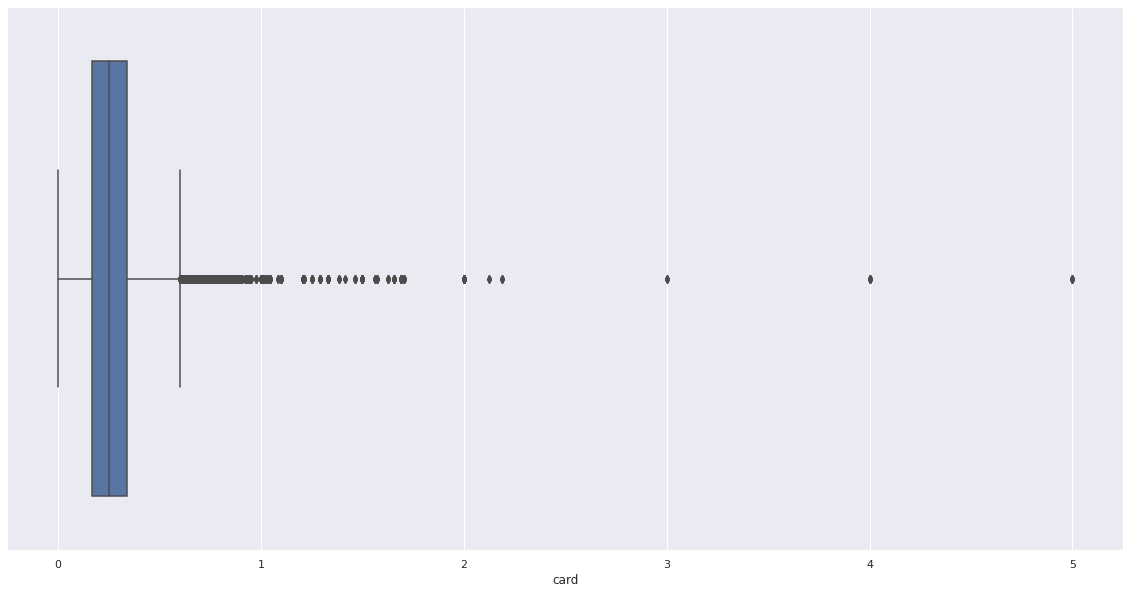

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=player_attributes_df["card"])
plt.plot()

In [ ]:
player_attributes_df[player_attributes_df["goal"]>1.49]["game_count"].value_counts()

1.0    225
2.0     37
5.0     10
Name: game_count, dtype: int64

In [ ]:
pd.Series(temp_df.loc[:, "home_player_1":"home_player_11"].values.ravel("K")).isnull().sum()

498

In [ ]:
temp_df.loc[:, "home_player_1":"home_player_11"].isnull().sum(axis=1).value_counts()

0    13765
1      418
2       27
3        4
4        2
6        1
dtype: int64

In [ ]:
event_df.reset_index(drop=True, inplace=True)

In [ ]:
event_df.loc[:, "home"] = temp_df.loc[event_df["match_api_id"]]["home_team_api_id"].reset_index(drop=True).astype(str) == event_df["team_id"].reset_index(drop=True)

In [ ]:
event_df.loc[event_df["team_id"].isnull(), "home"] = np.nan

In [ ]:
event_df

,match_api_id,event,player_id,player2_id,team_id,home
0,489042,goal,37799,38807,10261,False
1,489042,goal,24148,24154,10260,True
2,489042,goal,NaN,NaN,NaN,NaN
3,489043,goal,26181,39297,9825,True
4,489043,goal,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1760064,1992225,possession,NaN,NaN,NaN,NaN
1760065,1992226,possession,NaN,NaN,NaN,NaN
1760066,1992227,possession,NaN,NaN,NaN,NaN
1760067,1992228,possession,NaN,NaN,NaN,NaN


In [ ]:
temp_df.loc[:,"home_player_1":"away_player_11"].isnull().sum().sum()

1022

In [ ]:
temp_df

,id,country_id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_formation,away_formation
match_api_id,,,,,,,,,,,,,,,,,,,,,
489042,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,10260,10261,1,1,...,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00,1-4-4-2,1-4-4-1-1
489043,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,9825,8659,1,0,...,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00,1-4-4-2,1-4-5-1
489044,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,8472,8650,0,1,...,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73,1-4-4-2,1-4-4-2
489045,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,8654,8528,2,1,...,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80,1-4-4-2,1-4-4-2
489046,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,10252,8456,4,2,...,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75,1-4-4-2,1-4-5-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992225,25945,24558,24558,2015/2016,36,2016-05-25 00:00:00,9931,9956,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-2-3-1
1992226,25946,24558,24558,2015/2016,36,2016-05-25 00:00:00,7896,10190,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-3-3,1-4-1-4-1
1992227,25947,24558,24558,2015/2016,36,2016-05-25 00:00:00,10199,10179,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-4-2


In [ ]:
count_df = event_df.loc[event_df["home"] == True, ["match_api_id", "player_id", "event"]].groupby(["match_api_id", "player_id"]).count().groupby("match_api_id")["event"].rank(method="first").astype(int).reset_index().pivot(index="match_api_id", columns="event", values="player_id").astype(float)

In [ ]:
count_df.rename_axis(None, inplace=True)

In [ ]:
count_df

event,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
489042,24150.0,30620.0,30865.0,32569.0,30373.0,30362.0,24157.0,24154.0,30829.0,24148.0,NaN,NaN,NaN,NaN,NaN
489043,38835.0,36410.0,31013.0,30935.0,31291.0,26181.0,30843.0,26111.0,30960.0,39297.0,NaN,NaN,NaN,NaN,NaN
489044,30954.0,33316.0,38836.0,24446.0,38802.0,36786.0,17866.0,24410.0,30352.0,23927.0,NaN,NaN,NaN,NaN,NaN
489045,118390.0,23818.0,37169.0,37277.0,34543.0,23139.0,24223.0,24773.0,36394.0,NaN,NaN,NaN,NaN,NaN,NaN
489046,23282.0,38609.0,30357.0,23264.0,26165.0,24780.0,23782.0,23354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060642,41497.0,265924.0,32769.0,96532.0,183059.0,74034.0,415539.0,540307.0,195199.0,317156.0,NaN,NaN,NaN,NaN,NaN
2060643,612755.0,154239.0,30453.0,618878.0,166648.0,47041.0,288613.0,72518.0,108808.0,624166.0,127460.0,72656.0,NaN,NaN,NaN
2060644,166595.0,210278.0,213501.0,244966.0,24235.0,75447.0,41884.0,32569.0,30474.0,21446.0,248453.0,325916.0,NaN,NaN,NaN
2060645,212645.0,41865.0,438456.0,193439.0,41640.0,282723.0,30284.0,362212.0,237606.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
count_df = count_df.join(temp_df.loc[:,"home_player_1":"home_player_11"])

In [ ]:
count_df.loc[:,"home_player_1":"home_player_11"].isnull().sum().sum()

490

In [ ]:
count_df["values"] = np.nan

In [ ]:
for x in range(1,12):
  count_df["values"] = np.nan
  for i in range(1,12):
    count_df["predictions"] = count_df.loc[
      (~((count_df[i].isin(count_df["home_player_1"])) | 
      (count_df[i].isin(count_df["home_player_2"])) | 
      (count_df[i].isin(count_df["home_player_3"])) | 
      (count_df[i].isin(count_df["home_player_4"])) | 
      (count_df[i].isin(count_df["home_player_5"])) | 
      (count_df[i].isin(count_df["home_player_6"])) | 
      (count_df[i].isin(count_df["home_player_7"])) | 
      (count_df[i].isin(count_df["home_player_8"])) | 
      (count_df[i].isin(count_df["home_player_9"])) | 
      (count_df[i].isin(count_df["home_player_10"])) |
      (count_df[i].isin(count_df["home_player_11"])))), i]

    count_df["values"].fillna(count_df["predictions"], inplace=True)
  string = "home_player_" + str(x)
  count_df[string].fillna(count_df["values"], inplace=True)


In [ ]:
(~count_df["values"].isnull()).sum()

638

In [ ]:
count_df.loc[:,"home_player_1":"home_player_11"].isnull().sum().sum()

308

In [ ]:
temp_df[~temp_df.index.isin(count_df.index)]

,id,country_id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_formation,away_formation
match_api_id,,,,,,,,,,,,,,,,,,,,,
830105,5611,4769,4769,2010/2011,17,2010-12-12 00:00:00,9827,9851,0,0,...,3.25,4.00,2.05,3.1,3.60,2.10,3.1,3.40,1-4-1-2-2-1,1-4-1-2-2-1
830106,5612,4769,4769,2010/2011,17,2010-12-11 00:00:00,8521,10249,0,0,...,3.00,3.20,2.40,3.0,3.00,2.40,3.1,2.88,1-4-2-3-1,1-4-2-3-1
830126,5631,4769,4769,2010/2011,19,2010-12-22 00:00:00,8521,8592,0,0,...,3.20,2.20,3.50,3.0,2.15,3.40,3.1,2.10,1-4-2-3-1,1-4-1-2-2-1
830222,5698,4769,4769,2010/2011,24,2011-02-20 00:00:00,9941,9851,1,2,...,3.10,3.40,2.40,3.0,3.00,2.38,3.1,2.88,1-4-1-2-2-1,1-4-1-2-2-1
830296,5718,4769,4769,2010/2011,26,2011-03-05 00:00:00,9873,9829,0,0,...,3.20,3.75,2.10,3.1,3.40,2.10,3.2,3.30,1-4-1-2-2-1,1-4-1-2-2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506165,23711,21518,21518,2013/2014,36,2014-05-04 00:00:00,8302,10205,0,0,...,3.90,4.50,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-4-2
1506170,23716,21518,21518,2013/2014,36,2014-05-03 00:00:00,8371,9910,0,2,...,3.50,4.20,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-3-3
1992139,25848,24558,24558,2015/2016,18,2015-12-06 00:00:00,10191,9931,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-4-2,1-4-2-3-1


In [ ]:
temp_df.loc[temp_df.index.isin(count_df.index),"home_player_1":"home_player_11"] = count_df.loc[:,"home_player_1":"home_player_11"]

In [ ]:
count_df = event_df.loc[event_df["home"] == False, ["match_api_id", "player_id", "event"]].groupby(["match_api_id", "player_id"]).count().groupby("match_api_id")["event"].rank(method="first").astype(int).reset_index().pivot(index="match_api_id", columns="event", values="player_id").astype(float)
count_df.rename_axis(None, inplace=True)
count_df

event,1,2,3,4,5,6,7,8,9,10,11,12,13,14
489042,25518.0,30360.0,34574.0,24228.0,33852.0,30929.0,29581.0,40565.0,37799.0,38807.0,NaN,NaN,NaN,NaN
489043,24171.0,24728.0,24664.0,25922.0,36832.0,27267.0,31088.0,23257.0,NaN,NaN,NaN,NaN,NaN,NaN
489044,24134.0,24800.0,30889.0,46621.0,24635.0,37442.0,39647.0,37139.0,30853.0,30618.0,NaN,NaN,NaN,NaN
489045,24663.0,25150.0,41877.0,37684.0,111865.0,97988.0,127857.0,35327.0,NaN,NaN,NaN,NaN,NaN,NaN
489046,24208.0,24213.0,33963.0,42119.0,51553.0,107216.0,23939.0,40198.0,46403.0,47413.0,33633.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060642,33888.0,197352.0,301456.0,98254.0,428672.0,214972.0,130155.0,39295.0,30991.0,92666.0,206508.0,NaN,NaN,NaN
2060643,15403.0,161328.0,30682.0,210111.0,267371.0,276738.0,114558.0,292462.0,30714.0,41433.0,264842.0,96398.0,NaN,NaN
2060644,121044.0,177874.0,181995.0,30920.0,238838.0,309328.0,39540.0,50189.0,NaN,NaN,NaN,NaN,NaN,NaN
2060645,161660.0,174031.0,239287.0,31672.0,41816.0,150670.0,362113.0,309726.0,154246.0,195413.0,267911.0,244811.0,NaN,NaN


In [ ]:
count_df = count_df.join(temp_df.loc[:,"away_player_1":"away_player_11"])

In [ ]:
count_df.loc[:,"away_player_1":"away_player_11"].isnull().sum().sum()

518

In [ ]:
count_df["values"] = np.nan

In [ ]:
for x in range(1,12):
  count_df["values"] = np.nan
  for i in range(1,12):
    count_df["predictions"] = count_df.loc[
      (~((count_df[i].isin(count_df["away_player_1"])) | 
      (count_df[i].isin(count_df["away_player_2"])) | 
      (count_df[i].isin(count_df["away_player_3"])) | 
      (count_df[i].isin(count_df["away_player_4"])) | 
      (count_df[i].isin(count_df["away_player_5"])) | 
      (count_df[i].isin(count_df["away_player_6"])) | 
      (count_df[i].isin(count_df["away_player_7"])) | 
      (count_df[i].isin(count_df["away_player_8"])) | 
      (count_df[i].isin(count_df["away_player_9"])) | 
      (count_df[i].isin(count_df["away_player_10"])) |
      (count_df[i].isin(count_df["away_player_11"])))), i]

    count_df["values"].fillna(count_df["predictions"], inplace=True)
  string = "away_player_" + str(x)
  count_df[string].fillna(count_df["values"], inplace=True)


In [ ]:
(~count_df["values"].isnull()).sum()

621

In [ ]:
count_df.loc[:,"away_player_1":"away_player_11"].isnull().sum().sum()

316

In [ ]:
temp_df.loc[temp_df.index.isin(count_df.index),"away_player_1":"away_player_11"] = count_df.loc[:,"away_player_1":"away_player_11"]

In [ ]:
temp_df["id2"] = temp_df["id"]-1

In [ ]:
temp_df = temp_df.reset_index().set_index("id2")

In [ ]:
temp_df.loc[:,"home_player_1":"away_player_11"].isnull().sum().sum()

638

In [ ]:
df.loc[~df["shoton"].isnull()]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_formation,away_formation
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00,1-4-4-2,1-4-4-1-1
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00,1-4-4-2,1-4-5-1
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73,1-4-4-2,1-4-4-2
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80,1-4-4-2,1-4-4-2
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75,1-4-4-2,1-4-5-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25944,25945,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992225,9931,9956,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-2-3-1
25945,25946,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992226,7896,10190,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-3-3,1-4-1-4-1
25946,25947,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992227,10199,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-4-2
25947,25948,24558,24558,2015/2016,36,2016-05-25 00:00:00,1992228,10191,10192,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-4-2,1-4-4-2


In [ ]:
temp_df[temp_df.loc[:,"home_player_1":"away_player_11"].isnull().all(axis=1)]

,match_api_id,id,country_id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_formation,away_formation
id2,,,,,,,,,,,,,,,,,,,,,


In [ ]:
df.loc[:,"home_player_1":"away_player_11"].isnull().sum().sum()

29257

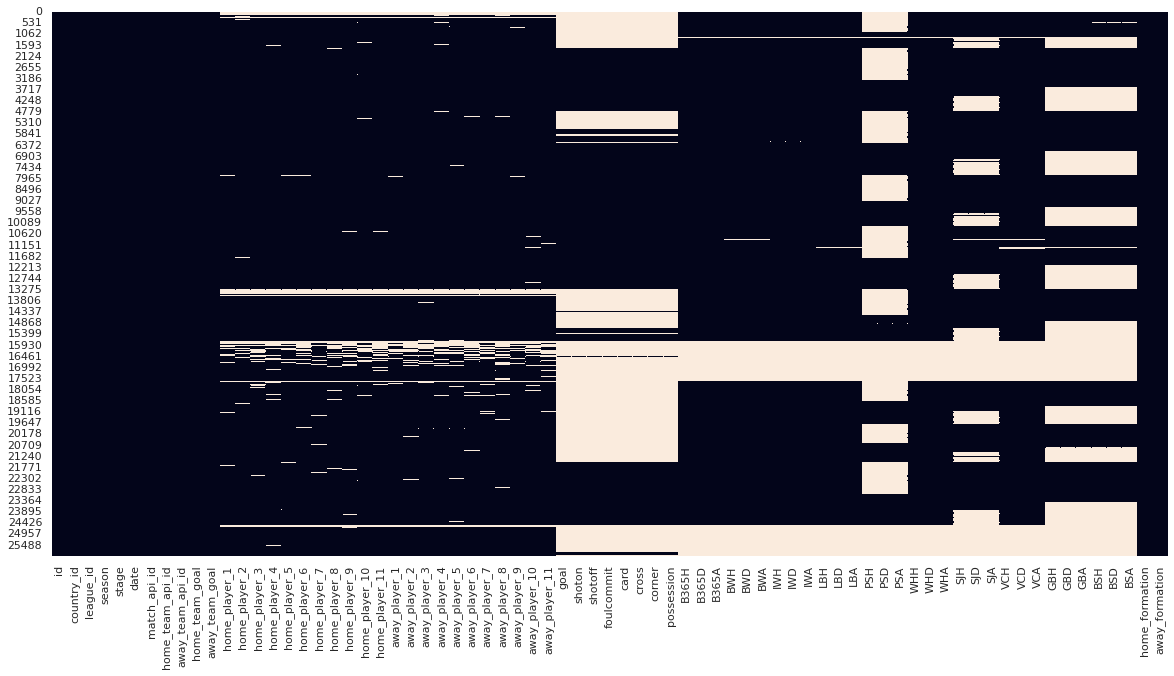

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
df.loc[~df["shoton"].isnull()] = temp_df

In [ ]:
df.loc[:,"home_player_1":"away_player_11"].isnull().sum().sum()

28873

In [ ]:
df[df.loc[:,"home_player_1":"away_player_11"].isnull().any(axis=1)]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_formation,away_formation
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,1-4-4-2,1-4-4-2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,1-4-4-2,1-4-4-2
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,1-4-4-2,1-4-4-2
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,1-4-4-2,1-4-4-2
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,1-4-4-2,1-4-4-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25955,25956,24558,24558,2015/2016,5,2015-08-12 00:00:00,1992072,10192,7896,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-1-4-1,1-4-1-2-3
25959,25960,24558,24558,2015/2016,6,2015-08-22 00:00:00,1992076,7896,9931,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-1-2-3,1-4-2-3-1
25964,25965,24558,24558,2015/2016,7,2015-08-29 00:00:00,1992081,7896,10199,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-1-2-3,1-4-4-2
25973,25974,24558,24558,2015/2016,8,2015-09-13 00:00:00,1992090,10179,7896,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-4-2-3-1,1-4-1-2-3


In [ ]:
null_team_player_set = df.loc[df.loc[:,"home_player_1":"home_player_11"].isnull().any(axis=1), "home_team_api_id"].tolist()

In [ ]:
null_team_player_set += df.loc[df.loc[:,"away_player_1":"away_player_11"].isnull().any(axis=1), "away_team_api_id"].tolist()

In [ ]:
null_team_player_set = set(null_team_player_set)

In [ ]:
len(null_team_player_set)

209

In [ ]:
def best_guess_players(row):
  stadium = ""
  if row.index.str.contains("home").any():
    stadium = "home"
  else:
    stadium = "away"
  for i in range(1, 12):
    if np.isnan(row[stadium+"_player_"+str(i)]):
      list_match_players = row.dropna().tolist()
      input_number = 0
      list_potential_players = player_count_df["player_"+str(i)].dropna().drop("total")
      list_potential_players = list_potential_players[~list_potential_players.index.isin(list_match_players)]
      if ((list_potential_players>10).any()) & (player_count_df.loc["total","player_"+str(i)]>30):
        input_number = list_potential_players.sort_values(ascending=False).index[0]
      else:
        input_number = np.nan
      row[stadium+"_player_"+str(i)] = input_number
  for i in range(1, 12):
    if np.isnan(row[stadium+"_player_"+str(i)]):
      list_match_players = row.dropna().tolist()
      list_potential_players = player_count_df["total"].dropna().drop("total")
      list_potential_players = list_potential_players[~list_potential_players.index.isin(list_match_players)]
      input_number = list_potential_players.sort_values(ascending=False).index[0]
      row[stadium+"_player_"+str(i)] = input_number
  return row

In [ ]:
df2 = df.copy()

In [ ]:
df = df2.copy()

In [ ]:
df2.loc[((df2.loc[:,"away_player_1":"away_player_11"].isnull().any(axis=1)) & (df2["away_team_api_id"] == 8242)), "away_player_1":"away_player_11"]

,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
15725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15804,NaN,NaN,NaN,NaN,NaN,13405.0,68839.0,NaN,NaN,95533.0,13383.0
15828,NaN,NaN,NaN,NaN,NaN,NaN,13405.0,NaN,95533.0,13383.0,NaN
15843,NaN,NaN,NaN,NaN,NaN,NaN,13405.0,NaN,95533.0,13383.0,NaN
15851,NaN,NaN,NaN,13405.0,95533.0,NaN,NaN,NaN,NaN,NaN,NaN
15868,NaN,NaN,NaN,NaN,NaN,95533.0,13405.0,NaN,NaN,13383.0,NaN


In [ ]:
num = 0
for team in null_team_player_set:
  print(team)
  all_players = np.unique(np.append(df.loc[df["home_team_api_id"] == team, "home_player_1":"home_player_11"].values.ravel("K"), df.loc[df["away_team_api_id"] == team, "away_player_1":"away_player_11"].values.ravel("K")))
  all_players = all_players[~np.isnan(all_players)]

  player_count_df = pd.DataFrame()
  player_count_df["index"] = all_players
  player_count_df.set_index("index", inplace=True)
  if player_count_df.index.shape[0] < 12:
    continue

  for i in range(1,12):
    column = df.loc[df["home_team_api_id"] == team, "home_player_"+str(i)].append(df.loc[df["away_team_api_id"] == team, "away_player_"+str(i)]).value_counts()
    player_count_df["player_"+str(i)] = column

  player_count_df["total"] = player_count_df.sum(axis=1)
  player_count_df.loc["total"] = player_count_df.sum(axis=0)

  temp_df = df.loc[((df.loc[:,"away_player_1":"away_player_11"].isnull().any(axis=1)) & (df["away_team_api_id"] == team)), "away_player_1":"away_player_11"]
  temp_df.apply(best_guess_players, axis=1)
  df.loc[((df.loc[:,"away_player_1":"away_player_11"].isnull().any(axis=1)) & (df["away_team_api_id"] == team)), "away_player_1":"away_player_11"] = temp_df

  temp_df = df.loc[((df.loc[:,"home_player_1":"home_player_11"].isnull().any(axis=1)) & (df["home_team_api_id"] == team)), "home_player_1":"home_player_11"]
  temp_df.apply(best_guess_players, axis=1)
  df.loc[((df.loc[:,"home_player_1":"home_player_11"].isnull().any(axis=1)) & (df["home_team_api_id"] == team)), "home_player_1":"home_player_11"] = temp_df

  num += 1
  print(str(num) + "/" + str(len(null_team_player_set)))
  

10243
1/209
10249
2/209
8203
3/209
10251
4/209
9746
5/209
9748
6/209
10264
7/209
10265
8/209
10267
9/209
9761
10/209
208931
11/209
9764
12/209
9765
13/209
10278
14/209
9768
15/209
9771
16/209
9772
17/209
9773
18/209
9777
19/209
8242
7730
20/209
8244
21/209
8245
22/209
9783
23/209
9788
24/209
9791
25/209
1601
26/209
9800
27/209
4170
28/209
9803
29/209
9804
30/209
9807
31/209
9809
32/209
9810
33/209
8277
34/209
8284
35/209
9824
36/209
9829
37/209
9830
38/209
9831
39/209
8295
40/209
9836
41/209
9837
42/209
9839
43/209
8305
44/209
8306
45/209
9851
46/209
8315
47/209
6269
48/209
9853
49/209
9857
50/209
9858
51/209
8322
52/209
9860
53/209
2182
54/209
2183
55/209
9864
56/209
9865
57/209
2186
58/209
7819
59/209
9868
60/209
9869
61/209
9867
62/209
9873
63/209
9874
64/209
274581
65/209
8342
66/209
9880
67/209
9882
68/209
8348
69/209
8350
70/209
7841
71/209
7842
72/209
7844
73/209
9904
74/209
9906
75/209
8371
76/209
9908
77/209
8370
78/209
9911
79/209
8388
80/209
9925
81/209
7878
82/209
9927
83/2

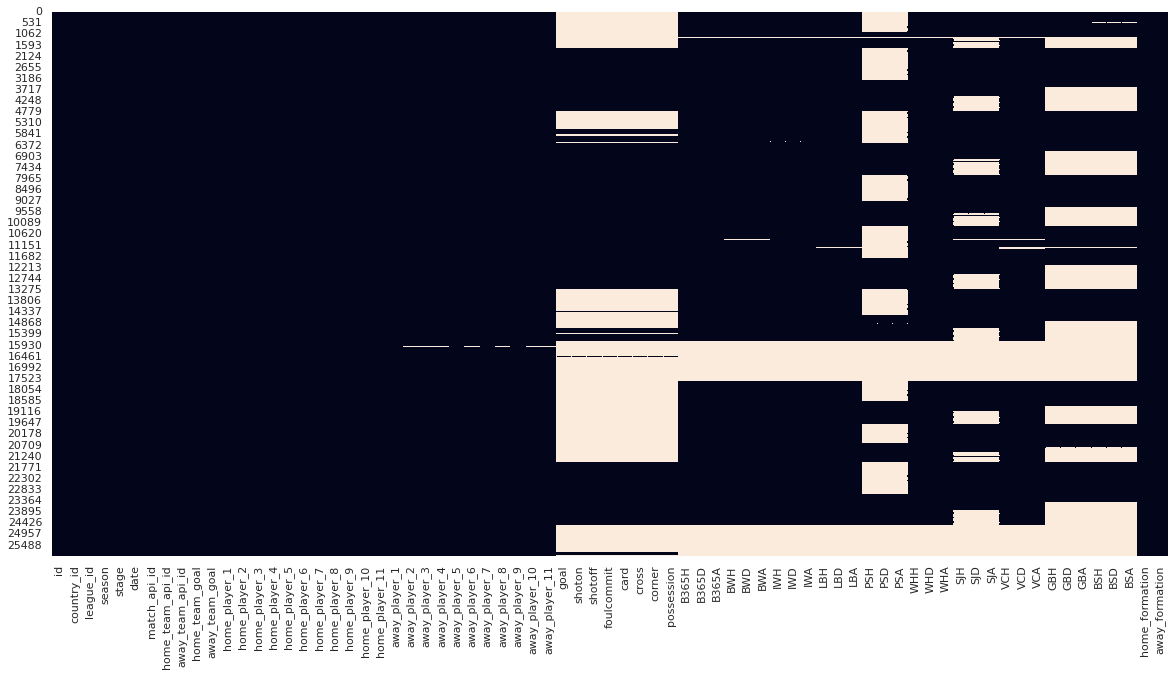

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
df.drop(df.loc[:,"goal":"BSA"].columns, axis=1, inplace=True)

In [ ]:
df.loc[:,"home_player_1":"away_player_11"].isnull().sum().sum()

541

In [ ]:
df.loc[df.loc[:,"home_player_1":"home_player_11"].isnull().any(axis=1), "home_team_api_id"].value_counts()

8242    30
Name: home_team_api_id, dtype: int64

In [ ]:
df.loc[df.loc[:,"away_player_1":"away_player_11"].isnull().any(axis=1), "away_team_api_id"].value_counts()

8242    30
Name: away_team_api_id, dtype: int64

In [ ]:
df[df["home_team_api_id"] == 8242].shape[0] + df[df["away_team_api_id"] == 8242].shape[0]

60

In [ ]:
df.loc[df.loc[:,"home_player_1":"home_player_11"].isnull().any(axis=1), "home_player_1":"home_player_11"]

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11
15749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15797,NaN,NaN,NaN,NaN,NaN,NaN,13405.0,NaN,95533.0,NaN,NaN
15811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15820,NaN,NaN,NaN,NaN,NaN,95533.0,NaN,13405.0,NaN,NaN,13383.0
15839,NaN,NaN,NaN,13405.0,NaN,95533.0,116756.0,NaN,NaN,13383.0,NaN
15858,NaN,NaN,NaN,13405.0,116756.0,95533.0,NaN,NaN,NaN,NaN,NaN
15880,NaN,NaN,NaN,NaN,95533.0,13405.0,NaN,NaN,NaN,13383.0,NaN


In [ ]:
team_df[team_df["team_id"]==8242]

,country_id,country,team_id,team_name
60,15722,Poland,8242,Odra Wodzisław


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().any().sum()

0

In [ ]:
query = """
  SELECT season, COUNT(*) count
  FROM Match
  GROUP BY 1
"""

#df = pd.read_sql_query(query, con)
#df